In [274]:
import os
import pandas as pd
import numpy as np
import time
from itertools import product
from joblib import parallel_backend, Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
import xgboost as xgb

from IPython.core.display import HTML
from codes.utils import *
from codes.process import *
from functools import reduce

%load_ext autoreload
%autoreload 2

random_seed=42
bed_root = '/home2/jpark/Projects/prs/data/bed'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [278]:
df_cdbk = pd.read_csv('data/cdbk_all.csv', encoding='EUCKR')
df_id = pd.read_csv('data/ID_Match_All_201909.txt', delim_whitespace=True)

In [279]:
check_kare_cdbk(df_cdbk, df_cdbk['변수설명'].str.contains('BMI', case=False), as_period=[1])

,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1232,1319,공개,신체계측,AS1_19_ANTHRO,AS1_BMI,비만 진단 - BMI,체중(kg)/(신장(m))2,2


In [280]:
get_var_from_kare(df_cdbk, 'AS1_BPSIT1LS', option='match_exact', display_cdbk=True)
get_var_from_kare(df_cdbk, 'AS1_BPSIT1RS', option='match_exact', display_cdbk=True)
get_var_from_kare(df_cdbk, 'AS1_BPSIT1LD', option='match_exact', display_cdbk=True)
get_var_from_kare(df_cdbk, 'AS1_BPSIT1RD', option='match_exact', display_cdbk=True)

,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1184,1271,공개,신체계측,AS1_19_ANTHRO,AS1_BPSIT1LS,앉은 자세 - 처음 좌측 팔 혈압 1회 sys,( )mmHg,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1186,1273,공개,신체계측,AS1_19_ANTHRO,AS1_BPSIT1RS,앉은 자세 - 처음 우측 팔 혈압 1회 sys,( )mmHg,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1185,1272,공개,신체계측,AS1_19_ANTHRO,AS1_BPSIT1LD,앉은 자세 처음 좌측 팔 혈압 1회 dia,( )mmHg,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1187,1274,공개,신체계측,AS1_19_ANTHRO,AS1_BPSIT1RD,앉은 자세 - 처음 우측 팔 혈압 1회 dia,( )mmHg,2


,RID,AS1_BPSIT1RD
0,EPI19_059_004991,100.0
1,EPI19_059_002013,90.0
2,EPI19_059_008802,96.0
3,EPI19_059_009517,90.0
4,EPI19_059_008273,66.0
...,...,...
10025,EPI19_059_007746,56.0
10026,EPI19_059_002220,84.0
10027,EPI19_059_006983,80.0
10028,EPI19_059_004239,84.0


# 값 확인
* fasting glucose ≥ 126 mg/dL
* post-challenge 2-h plasma glucose ≥ 200 mg/dL after a 75-g oral glucose load
* HbA1c ≥ 6.5%
### Age, Sex, BMI, SBP, DBP

In [285]:
# Glucose
check_kare_cdbk(df_cdbk, df_cdbk['변수설명'].str.contains('Glucose', case=False), as_period=[1])

# HbA1C
check_kare_cdbk(df_cdbk, df_cdbk['변수설명'].str.contains('HbA1C', case=False), as_period=[1])

,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1103,1190,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU0_ORI,Glucose (공복),( )mg/dL,2
1104,1191,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU0_TR,Glucose (공복),( )mg/dL,2
1105,1192,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU60_ORI,Glucose (OGTT 60분 후),( )mg/dL,2
1106,1193,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU60_TR,Glucose (OGTT 60분 후),( )mg/dL,2
1107,1194,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU120_ORI,Glucose (OGTT 120분 후),( )mg/dL,2
1108,1195,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU120_TR,Glucose (OGTT 120분 후),( )mg/dL,2
1156,1243,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU16_U,Urine (16) - Glucose,"-1=negative, 0=trace, 1=1 positive, 2=2 positi...",1


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1138,1225,공개,임상검사,AS1_18_BIOCHEM,AS1_HBA1C,HbA1C,( )%,2


In [286]:
df_GLU0 = get_var_from_kare(df_cdbk, 'AS1_GLU0_TR', option='match_exact', display_cdbk=True)  # Y1
df_GLU120 = get_var_from_kare(df_cdbk, 'AS1_GLU120_TR', option='match_exact', display_cdbk=True)  # Y2
df_HbA1C = get_var_from_kare(df_cdbk, 'AS1_HBA1C', option='match_exact', display_cdbk=True)  # Y3
df_AGE = get_var_from_kare(df_cdbk, 'AS1_AGE', option='match_exact', display_cdbk=True)  # Age
df_SEX = get_var_from_kare(df_cdbk, 'AS1_SEX', option='match_exact', display_cdbk=True)  # Sex
df_BMI = get_var_from_kare(df_cdbk, 'AS1_BMI', option='match_exact', display_cdbk=True)  # BMI
df_SBPL = get_var_from_kare(df_cdbk, 'AS1_BPSIT1LS', option='match_exact', display_cdbk=True)  # SBP
df_SBPR = get_var_from_kare(df_cdbk, 'AS1_BPSIT1RS', option='match_exact', display_cdbk=True) 
df_DBPL = get_var_from_kare(df_cdbk, 'AS1_BPSIT1LD', option='match_exact', display_cdbk=True)  # DBP
df_DBPR = get_var_from_kare(df_cdbk, 'AS1_BPSIT1RD', option='match_exact', display_cdbk=True)

,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1104,1191,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU0_TR,Glucose (공복),( )mg/dL,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1108,1195,공개,임상검사,AS1_18_BIOCHEM,AS1_GLU120_TR,Glucose (OGTT 120분 후),( )mg/dL,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1138,1225,공개,임상검사,AS1_18_BIOCHEM,AS1_HBA1C,HbA1C,( )%,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
4,4,공개,기본정보,AS1_01_EXAMINEE,AS1_AGE,연령,만( )세,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
3,3,공개,기본정보,AS1_01_EXAMINEE,AS1_SEX,성별,"1=남자, 2=여자",1


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1232,1319,공개,신체계측,AS1_19_ANTHRO,AS1_BMI,비만 진단 - BMI,체중(kg)/(신장(m))2,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1184,1271,공개,신체계측,AS1_19_ANTHRO,AS1_BPSIT1LS,앉은 자세 - 처음 좌측 팔 혈압 1회 sys,( )mmHg,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1186,1273,공개,신체계측,AS1_19_ANTHRO,AS1_BPSIT1RS,앉은 자세 - 처음 우측 팔 혈압 1회 sys,( )mmHg,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1185,1272,공개,신체계측,AS1_19_ANTHRO,AS1_BPSIT1LD,앉은 자세 처음 좌측 팔 혈압 1회 dia,( )mmHg,2


,일련번호,공개여부,테이블명_kor,테이블명_eng,변수명,변수설명,변수값,변수유형
1187,1274,공개,신체계측,AS1_19_ANTHRO,AS1_BPSIT1RD,앉은 자세 - 처음 우측 팔 혈압 1회 dia,( )mmHg,2


In [287]:
df_merged = reduce(lambda x, y: pd.merge(x, y, on='RID', how='outer'),
                   [df_GLU0, df_GLU120, df_HbA1C, df_AGE, df_SEX, df_BMI, df_SBPL, df_SBPR, df_DBPL, df_DBPR])
len(df_merged)

10030

In [288]:
df_merged = df_merged.dropna()
len(df_merged)

7461

In [289]:
df_merged

,RID,AS1_GLU0_TR,AS1_GLU120_TR,AS1_HBA1C,AS1_AGE,AS1_SEX,AS1_BMI,AS1_BPSIT1LS,AS1_BPSIT1RS,AS1_BPSIT1LD,AS1_BPSIT1RD
0,EPI19_059_004991,100.0,176.0,7.1,63,1,24.6,128.0,130.0,90.0,100.0
1,EPI19_059_002013,88.0,143.0,6.1,60,2,29.5,160.0,162.0,82.0,90.0
2,EPI19_059_008802,84.0,65.0,5.2,49,1,25.8,120.0,124.0,88.0,96.0
3,EPI19_059_009517,92.0,127.0,5.3,62,1,25.4,146.0,136.0,92.0,90.0
4,EPI19_059_008273,77.0,120.0,5.2,46,1,18.9,100.0,108.0,72.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...
10024,EPI19_059_000387,72.0,101.0,5.6,67,2,23.2,180.0,170.0,120.0,114.0
10025,EPI19_059_007746,86.0,124.0,5.5,47,2,22.6,70.0,90.0,58.0,56.0
10026,EPI19_059_002220,91.0,128.0,4.9,42,2,26.9,114.0,114.0,80.0,84.0
10027,EPI19_059_006983,71.0,100.0,5.8,62,1,21.3,118.0,110.0,80.0,80.0


In [290]:
df_merged['y1'] = df_merged.apply(lambda r: 1 if r['AS1_GLU0_TR'] >= 126 else 0, axis=1)
df_merged['y2'] = df_merged.apply(lambda r: 1 if r['AS1_GLU120_TR'] >= 200 else 0, axis=1)
df_merged['y3'] = df_merged.apply(lambda r: 1 if r['AS1_HBA1C'] >= 6.5 else 0, axis=1)
df_merged['AS1_SEX'] = df_merged.apply(lambda r: 1 if r['AS1_SEX'] == 1 else 0, axis=1) # 남자1->1, 여자 2->0, 기존 1=남자, 2=여자
df_merged['sbp'] = (df_merged['AS1_BPSIT1LS'] + df_merged['AS1_BPSIT1RS'])/2
df_merged['dbp'] = (df_merged['AS1_BPSIT1LD'] + df_merged['AS1_BPSIT1RD'])/2

In [291]:
df_merged

,RID,AS1_GLU0_TR,AS1_GLU120_TR,AS1_HBA1C,AS1_AGE,AS1_SEX,AS1_BMI,AS1_BPSIT1LS,AS1_BPSIT1RS,AS1_BPSIT1LD,AS1_BPSIT1RD,y1,y2,y3,sbp,dbp
0,EPI19_059_004991,100.0,176.0,7.1,63,1,24.6,128.0,130.0,90.0,100.0,0,0,1,129.0,95.0
1,EPI19_059_002013,88.0,143.0,6.1,60,0,29.5,160.0,162.0,82.0,90.0,0,0,0,161.0,86.0
2,EPI19_059_008802,84.0,65.0,5.2,49,1,25.8,120.0,124.0,88.0,96.0,0,0,0,122.0,92.0
3,EPI19_059_009517,92.0,127.0,5.3,62,1,25.4,146.0,136.0,92.0,90.0,0,0,0,141.0,91.0
4,EPI19_059_008273,77.0,120.0,5.2,46,1,18.9,100.0,108.0,72.0,66.0,0,0,0,104.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10024,EPI19_059_000387,72.0,101.0,5.6,67,0,23.2,180.0,170.0,120.0,114.0,0,0,0,175.0,117.0
10025,EPI19_059_007746,86.0,124.0,5.5,47,0,22.6,70.0,90.0,58.0,56.0,0,0,0,80.0,57.0
10026,EPI19_059_002220,91.0,128.0,4.9,42,0,26.9,114.0,114.0,80.0,84.0,0,0,0,114.0,82.0
10027,EPI19_059_006983,71.0,100.0,5.8,62,1,21.3,118.0,110.0,80.0,80.0,0,0,0,114.0,80.0


In [292]:
df_merged_with_id = pd.merge(df_id[['KNIHID', 'EPI19']], df_merged, left_on='EPI19', right_on='RID', how='inner')
len(df_merged_with_id)

6664

In [293]:
df_merged_with_id

,KNIHID,EPI19,RID,AS1_GLU0_TR,AS1_GLU120_TR,AS1_HBA1C,AS1_AGE,AS1_SEX,AS1_BMI,AS1_BPSIT1LS,AS1_BPSIT1RS,AS1_BPSIT1LD,AS1_BPSIT1RD,y1,y2,y3,sbp,dbp
0,KNIHGR001715,EPI19_059_009169,EPI19_059_009169,80.0,63.0,6.6,61,1,25.5,110.0,120.0,70.0,80.0,0,0,1,115.0,75.0
1,KNIHGR003156,EPI19_059_001772,EPI19_059_001772,82.0,92.0,5.5,52,1,22.4,106.0,108.0,80.0,78.0,0,0,0,107.0,79.0
2,KNIHGR002556,EPI19_059_009930,EPI19_059_009930,81.0,103.0,5.0,56,0,25.2,138.0,136.0,70.0,74.0,0,0,0,137.0,72.0
3,KNIHGR002594,EPI19_059_008761,EPI19_059_008761,85.0,128.0,5.6,42,0,23.9,112.0,120.0,78.0,80.0,0,0,0,116.0,79.0
4,KNIHGR007449,EPI19_059_008749,EPI19_059_008749,85.0,61.0,5.1,43,1,20.7,124.0,120.0,74.0,70.0,0,0,0,122.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6659,KNIHGR000470,EPI19_059_003510,EPI19_059_003510,82.0,100.0,5.3,60,0,19.3,114.0,116.0,88.0,94.0,0,0,0,115.0,91.0
6660,KNIHGR007598,EPI19_059_003675,EPI19_059_003675,101.0,155.0,5.7,67,1,24.1,152.0,164.0,86.0,94.0,0,0,0,158.0,90.0
6661,KNIHGR000195,EPI19_059_006366,EPI19_059_006366,91.0,98.0,5.9,44,1,29.2,110.0,118.0,74.0,74.0,0,0,0,114.0,74.0
6662,KNIHGR007666,EPI19_059_009264,EPI19_059_009264,98.0,99.0,5.8,40,1,26.1,114.0,120.0,86.0,88.0,0,0,0,117.0,87.0


In [294]:
df_fam = pd.read_csv('/home2/jpark/Projects/prs/data/bed/bed/chr_merged.fam', delim_whitespace=True, header=None)
sum(df_fam.iloc[:, 0] != 0)

0

In [295]:
df_merged_with_id['FID'] = 0
df_merged_with_id['IID'] = df_merged_with_id.apply(lambda r: f"{r['KNIHID']}_{r['KNIHID']}", axis=1)
df_merged_with_id['y'] = df_merged_with_id.apply(lambda r: r['y1'] or r['y2'] or r['y3'], axis=1)
df_merged_with_id = df_merged_with_id.rename(columns={'AS1_AGE': 'age', 'AS1_SEX': 'sex', 'AS1_BMI': 'bmi'})

In [296]:
df_merged_with_id

,KNIHID,EPI19,RID,AS1_GLU0_TR,AS1_GLU120_TR,AS1_HBA1C,age,sex,bmi,AS1_BPSIT1LS,...,AS1_BPSIT1LD,AS1_BPSIT1RD,y1,y2,y3,sbp,dbp,FID,IID,y
0,KNIHGR001715,EPI19_059_009169,EPI19_059_009169,80.0,63.0,6.6,61,1,25.5,110.0,...,70.0,80.0,0,0,1,115.0,75.0,0,KNIHGR001715_KNIHGR001715,1
1,KNIHGR003156,EPI19_059_001772,EPI19_059_001772,82.0,92.0,5.5,52,1,22.4,106.0,...,80.0,78.0,0,0,0,107.0,79.0,0,KNIHGR003156_KNIHGR003156,0
2,KNIHGR002556,EPI19_059_009930,EPI19_059_009930,81.0,103.0,5.0,56,0,25.2,138.0,...,70.0,74.0,0,0,0,137.0,72.0,0,KNIHGR002556_KNIHGR002556,0
3,KNIHGR002594,EPI19_059_008761,EPI19_059_008761,85.0,128.0,5.6,42,0,23.9,112.0,...,78.0,80.0,0,0,0,116.0,79.0,0,KNIHGR002594_KNIHGR002594,0
4,KNIHGR007449,EPI19_059_008749,EPI19_059_008749,85.0,61.0,5.1,43,1,20.7,124.0,...,74.0,70.0,0,0,0,122.0,72.0,0,KNIHGR007449_KNIHGR007449,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6659,KNIHGR000470,EPI19_059_003510,EPI19_059_003510,82.0,100.0,5.3,60,0,19.3,114.0,...,88.0,94.0,0,0,0,115.0,91.0,0,KNIHGR000470_KNIHGR000470,0
6660,KNIHGR007598,EPI19_059_003675,EPI19_059_003675,101.0,155.0,5.7,67,1,24.1,152.0,...,86.0,94.0,0,0,0,158.0,90.0,0,KNIHGR007598_KNIHGR007598,0
6661,KNIHGR000195,EPI19_059_006366,EPI19_059_006366,91.0,98.0,5.9,44,1,29.2,110.0,...,74.0,74.0,0,0,0,114.0,74.0,0,KNIHGR000195_KNIHGR000195,0
6662,KNIHGR007666,EPI19_059_009264,EPI19_059_009264,98.0,99.0,5.8,40,1,26.1,114.0,...,86.0,88.0,0,0,0,117.0,87.0,0,KNIHGR007666_KNIHGR007666,0


In [297]:
df_result = pd.merge(df_merged_with_id, df_fam, left_on='IID', right_on=1, how='inner')[['FID', 'IID', 'sex', 'age', 'bmi', 'sbp', 'dbp','y1', 'y2', 'y3', 'y']]
len(df_result)

3922

In [298]:
df_result.to_csv(f'{bed_root}/pheno_result.tsv', index=False, sep='\t')

In [302]:
df_result

,FID,IID,sex,age,bmi,sbp,dbp,y1,y2,y3,y
0,0,KNIHGR001715_KNIHGR001715,1,61,25.5,115.0,75.0,0,0,1,1
1,0,KNIHGR006138_KNIHGR006138,1,46,26.1,110.0,75.0,0,0,0,0
2,0,KNIHGR001096_KNIHGR001096,0,68,21.5,139.0,89.0,0,0,0,0
3,0,KNIHGR000679_KNIHGR000679,1,53,25.2,135.0,95.0,0,0,0,0
4,0,KNIHGR005869_KNIHGR005869,1,51,21.2,105.0,70.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3917,0,KNIHGR006726_KNIHGR006726,1,53,23.9,108.0,69.0,0,0,0,0
3918,0,KNIHGR000470_KNIHGR000470,0,60,19.3,115.0,91.0,0,0,0,0
3919,0,KNIHGR007598_KNIHGR007598,1,67,24.1,158.0,90.0,0,0,0,0
3920,0,KNIHGR000195_KNIHGR000195,1,44,29.2,114.0,74.0,0,0,0,0


In [301]:
df_result['sex'].value_counts()

0    1989
1    1933
Name: sex, dtype: int64

In [303]:
df_result['y'].value_counts()

0    3580
1     342
Name: y, dtype: int64

# Temp

In [1508]:
df_linear = pd.read_csv('/home2/jpark/Projects/prs/data/bed/bed_cv2/cv_4/cv_4_5_train_linear_y.assoc.logistic', delim_whitespace=True)

In [1509]:
df_linear = df_linear[df_linear['TEST']=='ADD']
df_linear = df_linear[df_linear['P'] != 'NA']
df_linear = df_linear[df_linear2['OR'] != 'NA']
df_linear['LOR'] = df_linear['OR'].apply(np.log)
df_linear = df_linear[df_linear['P'] < extract_p_value][['SNP', 'A1', 'LOR']]

/home2/jpark/.virtualenvs/jupyter/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [609]:
df_linear = df_linear[df_linear['TEST']=='ADD']
df_linear3[df_linear3['P'] < 5.0e-04]

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
8890,1,1:2412567:A:G,2412567,G,ADD,4000,17.020,3.870,0.000109
10442,1,1:2828211:T:C,2828211,C,ADD,4000,4.829,3.642,0.000271
25761,1,1:5399068:C:T,5399068,T,ADD,4000,3.674,3.492,0.000479
39861,1,1:8563775:C:T,8563775,T,ADD,4000,5.132,3.746,0.000180
39909,1,1:8585660:C:T,8585660,T,ADD,4000,5.132,3.746,0.000180
...,...,...,...,...,...,...,...,...,...
11588006,22,22:49389885:T:A,49389885,A,ADD,4000,8.504,3.520,0.000431
11588708,22,22:49477296:G:A,49477296,A,ADD,4000,4.053,3.885,0.000102
11591672,22,22:49798468:C:T,49798468,T,ADD,4000,3.543,3.573,0.000352
11593580,22,22:50100775:G:A,50100775,A,ADD,4000,3.762,3.580,0.000344


# Process

In [243]:
# Setting
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV #penalty ['l2', 'l1', 'elasticnet']
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [1534]:
# Create model dict
model_dict = {
    'Logistic Ridge': LogisticRegression(solver='saga', random_state=random_seed),
    'Logistic Lasso': LogisticRegression(penalty='l1', solver='saga', random_state=random_seed)
}

In [1973]:
score_df = pd.read_csv(get_bed_path('score', train_type, fold_num, y=y_value, ex=5000), delim_whitespace=True)

In [1975]:
label_df = pd.read_csv(get_bed_path('label', train_type, fold_num, y=y_value), delim_whitespace=True)

In [1977]:
label_df

,FID,IID,sex,age,bmi,sbp,dbp,y1,y2,y3,y
0,0,KNIHGR001715_KNIHGR001715,1,1.278977,0.292283,-0.257384,-0.400476,0,0,1,1
1,0,KNIHGR006138_KNIHGR006138,1,-0.544838,0.489796,-0.543964,-0.400476,0,0,0,0
2,0,KNIHGR001096_KNIHGR001096,0,2.130091,-1.024475,1.118204,0.850902,0,0,0,0
3,0,KNIHGR000679_KNIHGR000679,1,0.306275,0.193526,0.888939,1.387207,0,0,0,0
4,0,KNIHGR005869_KNIHGR005869,1,0.063100,-1.123231,-0.830545,-0.847397,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3132,0,KNIHGR004426_KNIHGR004426,1,-0.301663,-0.003988,-0.314700,-0.400476,0,0,0,0
3133,0,KNIHGR006726_KNIHGR006726,1,0.306275,-0.234420,-0.658597,-0.936781,0,0,0,0
3134,0,KNIHGR000470_KNIHGR000470,0,1.157389,-1.748691,-0.257384,1.029670,0,0,0,0
3135,0,KNIHGR000195_KNIHGR000195,1,-0.788014,1.510283,-0.314700,-0.489860,0,0,0,0


# 5-fold 데이터셋 구분

In [271]:
# get_score.py

# Screen by p-value over and get scores

In [211]:
extract_num_list = [1, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 5000, 7500,
                    10000, 20000, 30000, 50000]

In [ ]:
# Score 계산
%%time
for fold_num in range(1,6):
    for in_fold_num in ([None] + list(range(1,6))):
        for y_value in ['y', 'y1', 'y2', 'y3']:
            df_linear = pd.read_csv(get_bed_path('linear_yi_assoc', 'train', fold_num, in_fold_num=in_fold_num,  y=y_value) , delim_whitespace=True, error_bad_lines=False)
            df_linear = df_linear[df_linear['TEST']=='ADD']
            df_linear = df_linear[df_linear['P'] != 'NA']  # P가 계산되지 않은 경우 제외
            df_linear = df_linear[df_linear['OR'] != 'NA']  # BETA가 계산되지 않은 경우 제외
            df_linear['LOR'] = df_linear['OR'].apply(np.log)  # Log OR로 변경    

            for ex_num in extract_num_list:    
                df_linear_ex = df_linear.nsmallest(ex_num, 'P')[['SNP', 'A1', 'LOR']]  # P-value 기준으로 추출
                df_linear_ex.to_csv(get_bed_path('linear_yi_extract', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num), index=False, header=False, sep='\t')

                # score 계산
                for score_train_type in ['train', 'test']:
                    execute_cmd(f"plink --bfile {get_bed_path('keep_bed', score_train_type, fold_num, in_fold_num=in_fold_num)}"\
                        + f" --score {get_bed_path('linear_yi_extract', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)} sum"\
                        + f" --out {get_bed_path('linear_yi_score', score_train_type, fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}")

In [ ]:
# 선택된 SNP에 맞춰 BED 생성
%%time
for fold_num in range(1,6):
    for in_fold_num in ([None] + list(range(1,6))):
        for y_value in ['y', 'y1', 'y2', 'y3']:
            for ex_num in extract_num_list:
                extract_df = pd.read_csv(get_bed_path('linear_yi_extract', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num),
                             delim_whitespace=True, header=None)
                extract_df.iloc[:, 0].to_csv(get_bed_path('linear_yi_extract_snp', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num),
                                             index=False, header=False, sep='\t')
                
                for extract_train_type in ['train', 'test']:
                    execute_cmd(f"plink --bfile {get_bed_path('keep_bed', extract_train_type, fold_num, in_fold_num=in_fold_num)}"\
                        + f" --extract {get_bed_path('linear_yi_extract_snp', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}"\
                        + f" --recode A --out {get_bed_path('keep_bed_yi_ex', extract_train_type, fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}")

In [84]:
from sklearn.preprocessing import StandardScaler
#[1, 5, 10, 50, 1000, 5000, 10000]
#[2000, 3000, 4000, 15000, 30000]
#[1500, 2500, 3500, 4500, 7500]
def create_y_merge_df(train_type, fold_num, ex_num):
    y_value = 'y'
    label_df = pd.read_csv(get_bed_path('label', train_type, fold_num, y=y_value), delim_whitespace=True)
    score_df = pd.read_csv(get_bed_path('score', train_type, fold_num, y=y_value, ex=ex_num), delim_whitespace=True)
    ml_input = label_df.merge(score_df, how='inner', on='IID')[['IID', 'y', 'sex', 'age', 'bmi', 'sbp', 'dbp', 'SCORESUM']].rename(columns={'SCORESUM': f'{y_value}_input'})
#    for y_value in ['y1', 'y2', 'y3']:
#        label_y_df = pd.read_csv(get_bed_path('label', train_type, fold_num, y=y_value), delim_whitespace=True)
#        score_y_df = pd.read_csv(get_bed_path('score', train_type, fold_num, y=y_value), delim_whitespace=True)
#        ml_y_input = label_y_df.merge(score_y_df, how='inner', on='IID')[['IID', 'SCORESUM']].rename(columns={'SCORESUM': f'{y_value}_input'})
#        ml_input = ml_input.merge(ml_y_input, how='inner', on='IID')
    #print(ml_input.head(2))
    return ml_input

def analyze_model_dict(model_dict, X_train, X_test, y_train, y_test):
    train_result_list = []
    test_result_list = []
    model_list = []
    
    for model_name, model in model_dict.items():
        print('===========================')
        print(f'Model: {model_name}')
        print('===========================')
        
        # Train
        fitted_model = model.fit(X_train, y_train)
        #fitted_model = model.fit(X_train, X_train[['y1_input']])
        model_list.append(fitted_model)
        
        # For train data
        print('@ Train scores')
        train_pred = fitted_model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_score = precision_recall_fscore_support(y_train, train_pred)
        train_result_list.append([model_name, train_acc, train_score])
       
        # For test data
        print('@ Test scores')
        test_pred = fitted_model.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        test_score = precision_recall_fscore_support(y_test, test_pred)
        test_auc = roc_auc_score(y_test, fitted_model.decision_function(X_test))
        test_result_list.append([model_name, test_acc, test_score, test_auc])
        #test_result_list.append([model_name, test_acc, test_score])
       
        # Print
        #print(f'train_acc: {train_acc}, test_acc: {test_acc}')
        print(f'train_score: {train_score}')
        print(f'test_score: {test_score}')
    
        
    return train_result_list, test_result_list, model_list

In [247]:
# Create merge df
fold_train_result = []
fold_test_result = []
fold_model_result = []
ex_num = 50
#[1, 5, 10, 25, 50, 75, 250, 750, 10000, 20000]
#[125, 150, 175, 200]
for fold_num in range(1, 2):
    train_data = create_y_merge_df('train', fold_num, ex_num)
    test_data = create_y_merge_df('test', fold_num, ex_num)
    
#    for col in ('y_input', 'y1_input', 'y2_input', 'y3_input'):
#    for col in ['age', 'bmi', 'sbp', 'dbp', 'y_input']:
    for col in ['y_input']:
        scaler = normalize(train_data, col)
        normalize(test_data, col, scaler)
        
    # Split
    #X_train = train_data[['y1_input', 'y2_input', 'y3_input']]
    X_train = train_data[['y_input']]
#    X_train = train_data[['sex', 'age', 'bmi', 'sbp', 'dbp', 'y_input']]
#    X_train = train_data[['sex', 'age', 'bmi', 'sbp', 'dbp']]
    y_train = train_data[['y']]
    #X_test = test_data[['y1_input', 'y2_input', 'y3_input']]
    X_test = test_data[['y_input']]
#    X_test = test_data[['sex', 'age', 'bmi', 'sbp', 'dbp', 'y_input']]
#    X_test = test_data[['sex', 'age', 'bmi', 'sbp', 'dbp']]
    y_test = test_data[['y']]
    
# np.linspace(1e-10, 1e100, 10)
    # Create model dict
    model_dict = {
        'Logistic Ridge': LogisticRegressionCV(penalty='l2', class_weight='balanced', max_iter=1000, Cs=20, scoring='roc_auc', tol=1e-7, solver='saga',  random_state=2),
        'Logistic Lasso': LogisticRegressionCV(penalty='l1', class_weight='balanced', max_iter=1000, Cs=20, scoring='roc_auc', tol=1e-7, solver='saga', random_state=2),
        #'Random Forest': RandomForestClassifier(random_state=random_seed),
        #'SVM rbf': SVC(random_state=random_seed),
    }

    train_result, test_result, model_result = analyze_model_dict(model_dict, X_train, X_test, y_train, y_test)
    fold_train_result.append(train_result)
    fold_test_result.append(test_result)
    fold_model_result.append(model_result)

Model: Logistic Ridge


/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


@ Train scores
@ Test scores
train_score: (array([0.9443038 , 0.20338983]), array([0.78553879, 0.54166667]), array([0.85763556, 0.2957346 ]), array([2849,  288]))
test_score: (array([0.93015332, 0.06565657]), array([0.74692202, 0.24074074]), array([0.82852807, 0.1031746 ]), array([731,  54]))
Model: Logistic Lasso


/bin2/pkg_python36/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


@ Train scores
@ Test scores
train_score: (array([0.94435076, 0.20392157]), array([0.78624079, 0.54166667]), array([0.85807317, 0.2962963 ]), array([2849,  288]))
test_score: (array([0.93027211, 0.06598985]), array([0.74829001, 0.24074074]), array([0.82941622, 0.10358566]), array([731,  54]))


In [241]:
for method_num in range(len(model_dict)):
    print(fold_train_result[0][method_num][0])
    print(f'accuracy: {np.mean([x[method_num][1] for x in fold_train_result]):.6f}')
    print(f'precision: {np.mean([x[method_num][2][0][1] for x in fold_train_result]):.6f}')
    print(f'recall: {np.mean([x[method_num][2][1][1] for x in fold_train_result]):.6f}')
    print(f'f1: {np.mean([x[method_num][2][2][1] for x in fold_train_result]):.6f}')

Logistic Ridge
accuracy: 0.775901
precision: 0.212205
recall: 0.531250
f1: 0.303271
Logistic Lasso
accuracy: 0.770163
precision: 0.207827
recall: 0.534722
f1: 0.299320


In [242]:
for method_num in range(len(model_dict)):
    print(fold_test_result[0][method_num][0])
    print(f'accuracy: {np.mean([x[method_num][1] for x in fold_test_result]):.6f}')
    print(f'precision: {np.mean([x[method_num][2][0][1] for x in fold_test_result]):.6f}')
    print(f'recall: {np.mean([x[method_num][2][1][1] for x in fold_test_result]):.6f}')
    print(f'f1: {np.mean([x[method_num][2][2][1] for x in fold_test_result]):.6f}')
    print(f'auc: {np.mean([x[method_num][3] for x in fold_test_result]):.6f}')

Logistic Ridge
accuracy: 0.728662
precision: 0.070270
recall: 0.240741
f1: 0.108787
auc: 0.517721
Logistic Lasso
accuracy: 0.722293
precision: 0.068421
recall: 0.240741
f1: 0.106557
auc: 0.517721


In [250]:
temp_df = pd.concat([pd.DataFrame(X_test, columns=['y_input']), pd.DataFrame(y_test, columns=['y'])], axis=1)

In [251]:
temp_df

,y_input,y
0,0.318960,1
1,1.228690,0
2,5.517000,0
3,0.871342,0
4,0.437228,0
...,...,...
780,7.387150,0
781,2.932780,0
782,1.704300,0
783,1.346950,0


In [258]:
temp_df[temp_df.y==1]['y_input'].to_numpy()

array([ 0.31896  ,  8.95838  ,  1.7043   ,  0.       ,  4.12838  ,
        1.82257  ,  0.437228 ,  0.357345 ,  2.69391  ,  0.357345 ,
        0.871342 ,  2.2183   ,  1.73212  , -0.0383844,  0.832957 ,
        4.12308  ,  3.80412  ,  3.62341  ,  1.34695  ,  5.62669  ,
        8.3092   ,  1.34695  ,  5.82718  ,  8.45959  ,  1.82257  ,
       14.0375   ,  9.80655  ,  1.34695  ,  1.74268  ,  1.52223  ,
        1.74268  ,  2.41878  ,  2.77613  ,  1.34695  ,  1.74268  ,
       -0.156653 ,  1.69374  ,  0.437228 ,  0.714689 ,  0.357345 ,
        6.51013  ,  9.88657  ,  1.74268  , -0.0383844,  9.80655  ,
        0.       ,  2.2183   ,  1.06642  ,  5.70048  ,  0.832957 ,
        7.6196   ,  1.73212  ,  7.90115  ,  2.08946  ])

(-1, 27)

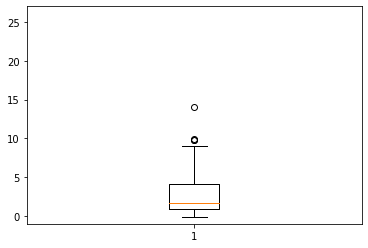

In [268]:
plt.boxplot(temp_df[temp_df.y==1]['y_input'].to_numpy())
plt.ylim(-1, 27)

(-1, 27)

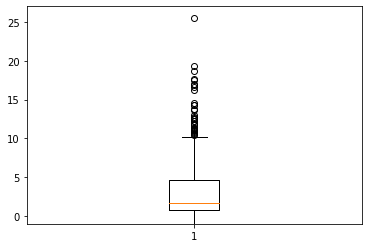

In [267]:
plt.boxplot(temp_df[temp_df.y==0]['y_input'].to_numpy())
plt.ylim(-1, 27)

In [72]:
fold_model_result[0][1].scores_

{1: array([[0.5       , 0.78297036, 0.77797943, 0.7776467 , 0.7776467 ],
        [0.5       , 0.75907441, 0.76037508, 0.76052632, 0.76049607],
        [0.5       , 0.75765105, 0.75837828, 0.75804497, 0.75804497],
        [0.5       , 0.77620806, 0.77867036, 0.77830102, 0.77830102],
        [0.5       , 0.78861188, 0.79476762, 0.79498307, 0.79498307]])}

In [73]:
sum([0.5       , 0.78297036, 0.77797943, 0.7776467 , 0.7776467])/5

0.723248638

# end

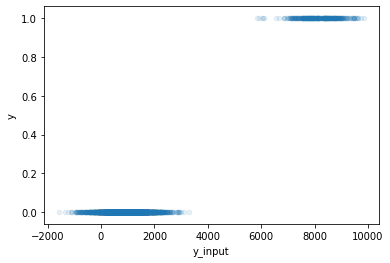

In [1170]:
fold_num = 1
train_data = create_y_merge_df('train', fold_num)
train_data[['y', 'y_input']].plot.scatter('y_input', 'y', alpha=0.1)